In [12]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
%matplotlib inline

from rl_framework import *
from manage_orderbooks import *
from orderbook_trade_simulator import *

# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:19.dict'
currency_pair = 'USDT_BTC'
offset = 0
orderbooks, timestamps = load_orderbook_snapshot(infile=filename, first_line=offset+0, last_line=offset+300)
# display(timestamps)
print(len(orderbooks), len(timestamps), len(orderbooks[0]))
# orderbooks = orderbooks[:1000]

100%|██████████| 300/300 [00:03<00:00, 75.59it/s]

Loaded Orderbooks: 300
(300, 300, 908)


In [39]:
V = 40  # trading volume
T = 10  # Time horizon: 10 periods -> P*T = 20 minutes
P = 2  # period length
episodes = 1

[u'2016-11-08T10:00:01.739243',
 u'2016-11-08T10:10:02.028311',
 u'2016-11-08T10:20:02.036923',
 u'2016-11-08T10:30:01.712482',
 u'2016-11-08T10:40:01.742116',
 u'2016-11-08T10:50:01.325842',
 u'2016-11-08T11:01:02.175009',
 u'2016-11-08T11:11:02.020851',
 u'2016-11-08T11:21:01.739499',
 u'2016-11-08T11:31:01.495877',
 u'2016-11-08T11:41:01.816348',
 u'2016-11-08T11:51:01.370763',
 u'2016-11-08T12:01:01.236021',
 u'2016-11-08T12:11:01.254411',
 u'2016-11-08T12:21:01.995539',
 u'2016-11-08T12:31:01.991553',
 u'2016-11-08T12:41:01.880422',
 u'2016-11-08T12:51:01.285983',
 u'2016-11-08T13:01:01.295752',
 u'2016-11-08T13:11:01.335489']

,Amount,Price,Type
1022,0.000220,708.600000,bid
1023,0.199808,708.900000,bid
1024,5.567642,709.100000,bid
1025,0.000000,709.549905,center
1026,0.699330,710.000000,ask
1027,0.000504,710.070000,ask
1028,0.000400,710.100000,ask


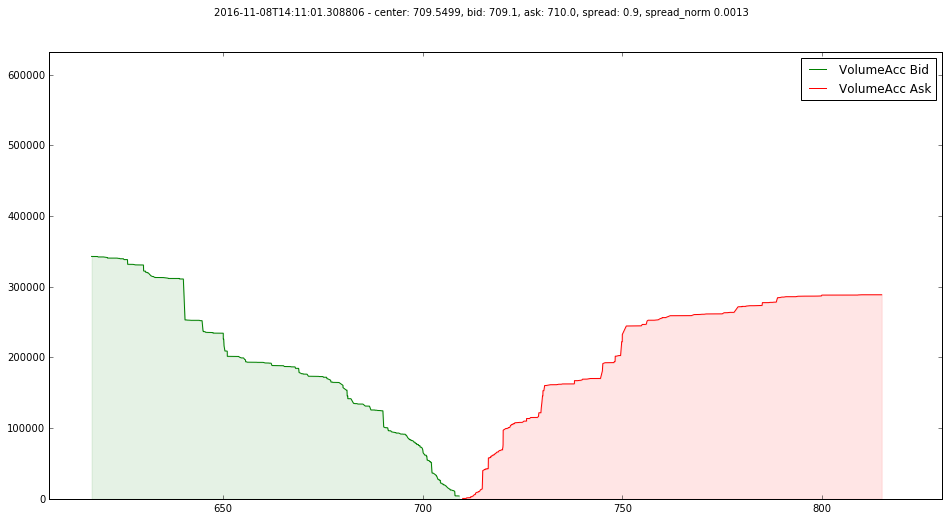

In [15]:
episode_windows = []
for e in range(0,episodes):
    window = {'orderbooks': [orderbooks[e*T*P + idx].copy() for idx in range(T*P)],
              'timestamps': [timestamps[e*T*P + idx] for idx in range(T*P)]}
    episode_windows.append(window)

# test
stepsize = 10 # only look at every 10th orderbook, ignore 9/10 snapshots
episode_windows = []
for e in range(0,episodes):
    window = {'orderbooks': [orderbooks[stepsize*(e*T*P + idx)].copy() for idx in range(T*P)],
              'timestamps': [timestamps[stepsize*(e*T*P + idx)] for idx in range(T*P)]}
    episode_windows.append(window)
display(episode_windows[0]['timestamps'])
# test end

df = orderbooks[-50]
display(orderbook_preview(df, 3))

plot_orderbook(df, timestamps[-50], range_factor=1.17)

In [63]:
obs = episode_windows[0]['orderbooks']
timestamps = episode_windows[0]['timestamps']
ots = OrderbookTradingSimulator()

%time ots.trade_timespan(obs[0:20], timestamps[0:20][0], timespan=20, must_trade=False, volume=50, limit=707, verbose=False)
display(ots.history)

CPU times: user 3.09 s, sys: 6.52 ms, total: 3.09 s
Wall time: 3.1 s


,ASK,BID,CENTER,LIMIT,SPREAD,TIMESPAN,VOLUME,avg,cashflow,cost,cost_avg,high,low,volume_left,volume_traded
2016-11-08T10:00,705.45,705.0,705.224976,707,0.45,20,50,706.37728,-26645.55101,43.466561,1.152304,707.0,705.0,12.278584,37.721416


In [59]:
STATE_DIM = 2
actions = [-1, 0, 1, 3, None]
NUM_ACTIONS = len(actions)

In [17]:
def base_model():
    model = Sequential()
    model.add(Dense(64, input_dim=STATE_DIM, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(NUM_ACTIONS, activation='linear'))
    model.compile(loss='mse', optimizer='Adam')
    return model

model = base_model()

In [40]:
max_steps = T
epochs = 3
gamma = 0.9

MAX_EXPLORATION_RATE = 1.
MIN_EXPLORATION_RATE = 0.05
DECAY_RATE = 0.01
epsilon = 1.

bufferSize = 5
batchSize = 3
replay = Memory(bufferSize)
# stores tuples of (S, A, R, S')

for i_episode in range(epochs):
    # i_episode = 0 ## test
    obs = episode_windows[0]['orderbooks']
    timestamps = episode_windows[0]['timestamps']

    ots = OrderbookTradingSimulator()
    
    volume = V
    time_left = T
    must_trade = False
    
    state = np.array([volume, time_left])
    # state = discretize_state(state)
    
    acc_cost = 0
    for step in range(max_steps):
        qval = model.predict(state.reshape(1, STATE_DIM))
        # print("     {}".format(qval))
            
        if random.random() < epsilon:
            # choose random action
            action = random.randint(0, len(actions)-1)
            # print("{}: random action {}".format(action, actions[action]))
        else:
            # choose best action from Q(s,a) values
            action = np.argmin(qval)
            # print("{}: action {}".format(action, actions[action]))

        ob = obs[step*P]
        # display(orderbook_preview(ob, 5))
        # display(orderbook_statistics(ob, currency_pair, timestamps[step*P]))
        
        ask = get_ask(ob)
        if not actions[action]:
            lim = None
        else:
            lim = ask + actions[action]
            
            
        if step == max_steps-1:
            must_trade = True

        new_ob = ots.trade_timespan(obs[step*P:(step+1)*P],
                                timestamps[step*P],
                                timespan=P, must_trade=must_trade,
                                volume=volume, limit=lim, verbose=False)
        
        volume = ots.history.volume_left.values[-1]
        time_left -= 1
        new_state = np.array([volume, time_left])
        cost = ots.history.cost.values[-1]
        
        acc_cost += cost
        
        replay.add((state, action, cost, new_state))
        if (replay.size() >= bufferSize):
            # wait for buffer to be filled, before getting started with training
            minibatch = replay.get_random_samples(batchSize)           
            
            X_train = []
            y_train = []
            for memory in minibatch:
                state_m, action_m, cost_m, new_state_m = memory
                
                qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                y = np.zeros((1, NUM_ACTIONS))
                y[:] = qval_old[:]
                
                qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                maxQ = np.max(qval_new_m)
                
                update = cost_m + (gamma*maxQ)
                y[0][action_m] = update  # target output

                X_train.append(state_m.reshape(STATE_DIM,))
                y_train.append(y.reshape(NUM_ACTIONS,))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
                        
            # print("Game #: %s" % (i_episode,))
            model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
        state = new_state
        if volume == 0:
            break
       
    # reduce exploration rate
    if epsilon > MIN_EXPLORATION_RATE:
        epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
    info = "{:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, last_cost {}, steps: {}"\
            .format(i_episode+1, epochs, epsilon,  acc_cost, cost, step)
    print(info)
    # if epsilon > 0:
    #     epsilon -= (1.5/epochs)
        

No shares left at t=1 (self.t=4), Done!
   1/3: epsilon=1.000, acc_cost: 73.85117, last_cost 31.0128362303, steps: 1
No shares left at t=0 (self.t=9), Done!
   2/3: epsilon=0.990, acc_cost: 86.87148, last_cost 26.1764674021, steps: 4
No shares left at t=0 (self.t=3), Done!
   3/3: epsilon=0.980, acc_cost: 74.58984, last_cost 31.7515037057, steps: 1


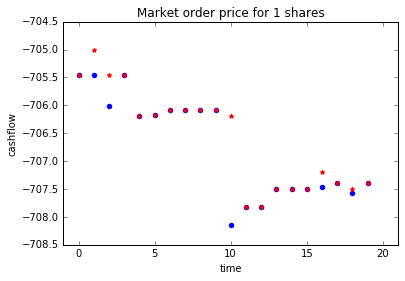

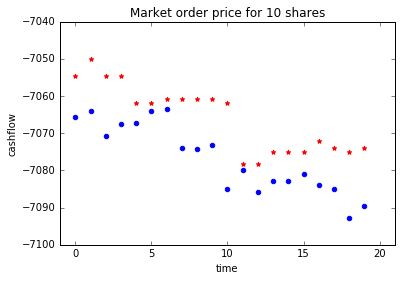

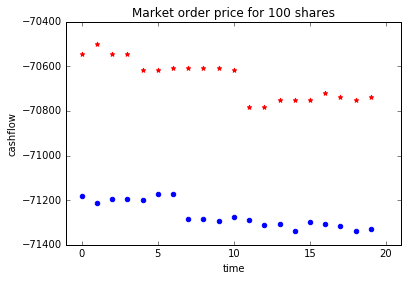

In [19]:
for vol in [1, 10, 100]:
    for i, test in enumerate(obs):
        test = test.copy()
        val = test[test.Type == 'center'].Price.values[0]
        trader = OrderbookTradingSimulator()
        res = trader.check_market_value(test, volume=vol)

        plt.scatter(i, res, color='blue')
        plt.scatter(i, vol * -1. * get_ask(test), color='red', marker='*')
    plt.title("Market order price for {} shares".format(vol))
    plt.ylabel("cashflow")
    plt.xlabel("time")
    plt.xlim((-1,21))
    plt.show()

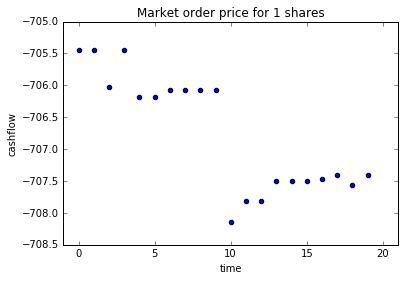

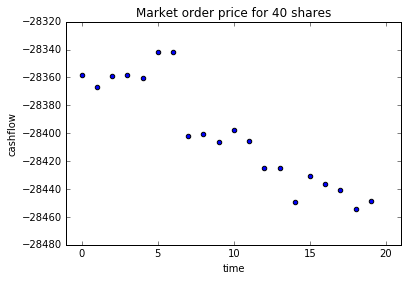

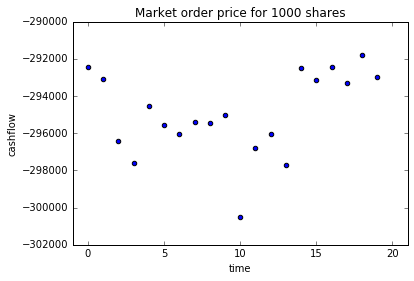

AttributeError: Unknown property col

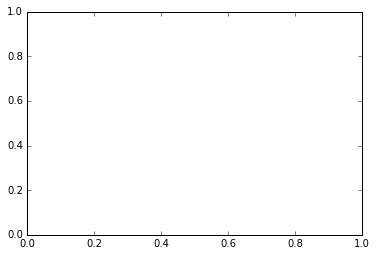

In [20]:
vol = 1
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 40
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 1000
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 10000
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res, col='blue')
    
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()